# Preprocessing Audiograms

This notebook preprocesses the audiograms in preparation for further analysis.

The steps include recalibration for a specific participant, optional removal of initialization-phase data, fixing of truncated audiograms, and resampling of the audiograms.

Specifically, the notebook performs the following operations:

1. **Recomputation**: Recomputes the audiograms for each participant. This involves fixing calibration issues for 'eqdcwr' and optionally removing the initialization data. This step is performed using the `recompute` function.

2. **Fixing Truncated Audiograms**: If the recomputed audiogram doesn't cover the entire frequency range, this step shifts the tested levels by 20 dB HL, re-does the request to the API, and then lowers the audiogram by 20 dB HL. This is done using the `fix_truncated_audiogram` function.

3. **Saving Recomputed Audiograms**: The recomputed audiograms are saved using the `save_recomputed_audiograms` function. If the recomputed audiograms have already been saved, the function fetches the previously recomputed data instead of recomputing it again.

4. **Plotting Recomputed Audiograms**: The recomputed audiograms for each participant are plotted using the `plot_recomputed_audiograms` function.

5. **Resampling Audiograms**: The audiograms are resampled to 100 data points using the `resample_audiograms` function. The resampled audiograms are then plotted.

This notebook should be run after fixing the Continuous responses with the notebook `fix_continuous_responses.ipynb`, as it creates the data files this script reads from. Otherwise, no data will be found for the Continuous paradigm (no files suffixed `*_fixed.pkl`)


In [1]:
from matplotlib import cm

from funcs.resample_audiograms import *

### Set some parameters

In [2]:
# Set path to raw data
raw_data_path = get_path("raw_data")

# Choose whether to keep init data or recompute audiograms without them
remove_init = False

# Set path to audiograms accordingly
aud_path = os.path.join(get_path("audiograms"), "no_init" if remove_init else "with_init")

# Choose participants to include
participants = exclude_participants(os.listdir(raw_data_path))

# Choose whether to overwrite audiograms
overwrite_existing_audiograms = True

In [3]:
preds = ['none', 'time', 'frequency', 'both']

freq_range = 125, 8000
xfreqs = np.geomspace(freq_range[0], freq_range[1], num=100)  # for resampling

colormap = cm.get_cmap('turbo', len(participants))

In [4]:
preproc = PreprocMain()

### Randomized paradigm

#### Load and recompute Randomized data

In [5]:
print("------------------------ BAYESIAN DATA ------------------------")
paradigm = 'Bayesian'

raw_data_Bayes = {}
init_dataB = {}

for participant in participants:

    # Fetch Bayesian data
    # print(os.path.join(raw_data_path, participant, paradigm))
    raw_data_Bayes[participant] = fetch_audiogram_data(participant, paradigm)
    if raw_data_Bayes[participant] is not None:
        # Fetch initialization phase data
        raw_data_Bayes[participant]['init'] = fetch_audiogram_data(participant, paradigm, init=True)
    else:
        print(f"No audiogram found for participant {participant}...")

bayes_aud_dir = set_audiograms_directory(aud_path, paradigm)

# Recompute audiograms if needed, or load already recomputed audiograms
recomputed_Bayes = preproc.load_or_recompute_and_save_audiograms(
    raw_data_Bayes, bayes_data=raw_data_Bayes, paradigm=paradigm, remove_initialization=remove_init, aud_dir=bayes_aud_dir, overwrite=overwrite_existing_audiograms)

------------------------ BAYESIAN DATA ------------------------
----------------------------------------------------
tlvjds
Saving audiogram of tlvjds in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------------------------------------------
nlhglm
Saving audiogram of nlhglm in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------------------------------------------
klxufm
Saving audiogram of klxufm in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------------------------------------------
rdzaqd
Saving audiogram of rdzaqd in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------------------------------------------
vqnuwy
Saving audiogram of vqnuwy in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------------------------------------------
wfoooa
Saving audiogram of wfoooa in there_will_be_beeps/data/audiograms/with_init/Bayesian...
------------------------------------------------

## Cluster paradigm


#### Load and recompute Cluster data

In [6]:
print("------------------------------ CLUSTER DATA ------------------------------")
paradigm = 'Cluster'

clus_aud_dir = set_audiograms_directory(aud_path, paradigm)

raw_data_Clus = {}
recomputed_Clus = {}

for pred in preds:
    print("\n-------------", pred.upper(), "-------------\n")
    raw_data_Clus[pred] = {}

    for participant in participants:
        raw_data_Clus[pred][participant] = fetch_audiogram_data(participant, paradigm, pred)

    recomputed_Clus[pred] = preproc.load_or_recompute_and_save_audiograms(
        raw_data_Clus[pred], bayes_data=raw_data_Bayes, paradigm=paradigm, pred=pred,
        remove_initialization=remove_init, aud_dir=clus_aud_dir, overwrite=overwrite_existing_audiograms
    )


------------------------------ CLUSTER DATA ------------------------------

------------- NONE -------------

----------------------------------------------------
tlvjds
Saving none audiogram of tlvjds in there_will_be_beeps/data/audiograms/with_init/Cluster...
----------------------------------------------------
nlhglm
Saving none audiogram of nlhglm in there_will_be_beeps/data/audiograms/with_init/Cluster...
----------------------------------------------------
klxufm
Saving none audiogram of klxufm in there_will_be_beeps/data/audiograms/with_init/Cluster...
----------------------------------------------------
rdzaqd
Saving none audiogram of rdzaqd in there_will_be_beeps/data/audiograms/with_init/Cluster...
----------------------------------------------------
vqnuwy
Saving none audiogram of vqnuwy in there_will_be_beeps/data/audiograms/with_init/Cluster...
----------------------------------------------------
wfoooa
Saving none audiogram of wfoooa in there_will_be_beeps/data/audiograms

## Continuous paradigm

### Load and recompute Continuous audiograms

In [7]:
print("------------------------------ CONTINUOUS DATA ------------------------------")
paradigm = 'Continuous'
cont_aud_dir = set_audiograms_directory(aud_path, 'Continuous')

raw_data_Con = {}
recomputed_Con = {}

for pred in preds:
    print(pred.upper())
    raw_data_Con[pred] = {}

    for participant in participants:
        raw_data_Con[pred][participant] = fetch_audiogram_data(participant, paradigm, pred)

    recomputed_Con[pred] = preproc.load_or_recompute_and_save_audiograms(
        raw_data_Con[pred],  raw_data_Bayes, paradigm=paradigm, aud_dir=cont_aud_dir,
        pred=pred, remove_initialization=remove_init, overwrite=overwrite_existing_audiograms
    )

------------------------------ CONTINUOUS DATA ------------------------------
NONE
----------------------------------------------------
tlvjds
Saving none audiogram of tlvjds in there_will_be_beeps/data/audiograms/with_init/Continuous...
----------------------------------------------------
nlhglm
Saving none audiogram of nlhglm in there_will_be_beeps/data/audiograms/with_init/Continuous...
----------------------------------------------------
klxufm
Saving none audiogram of klxufm in there_will_be_beeps/data/audiograms/with_init/Continuous...
----------------------------------------------------
rdzaqd
Saving none audiogram of rdzaqd in there_will_be_beeps/data/audiograms/with_init/Continuous...
----------------------------------------------------
vqnuwy
Saving none audiogram of vqnuwy in there_will_be_beeps/data/audiograms/with_init/Continuous...
----------------------------------------------------
wfoooa
Saving none audiogram of wfoooa in there_will_be_beeps/data/audiograms/with_init/C

## Plot recomputed audiograms

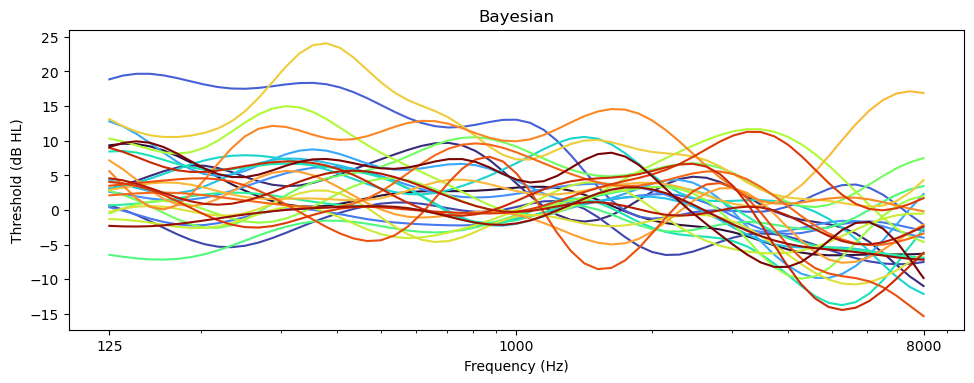

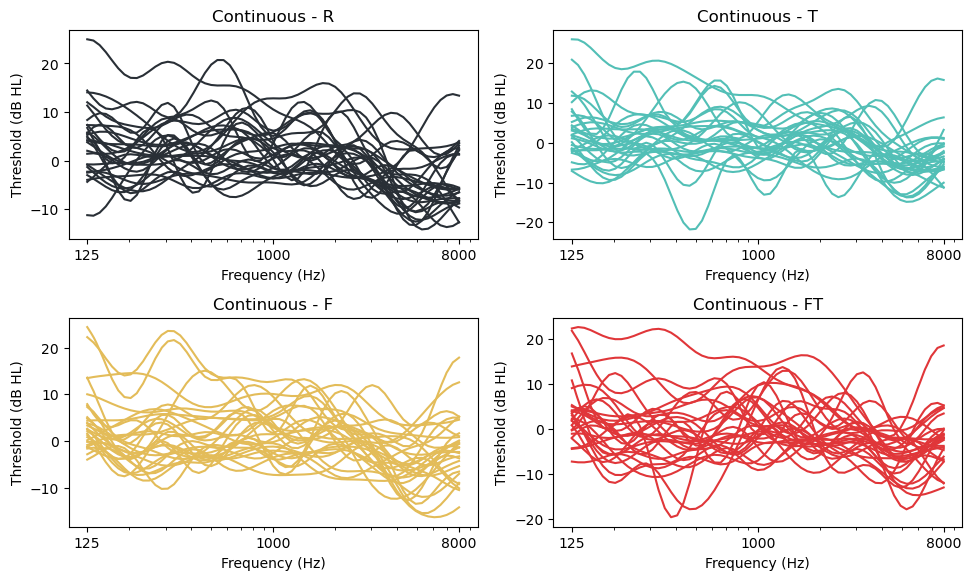

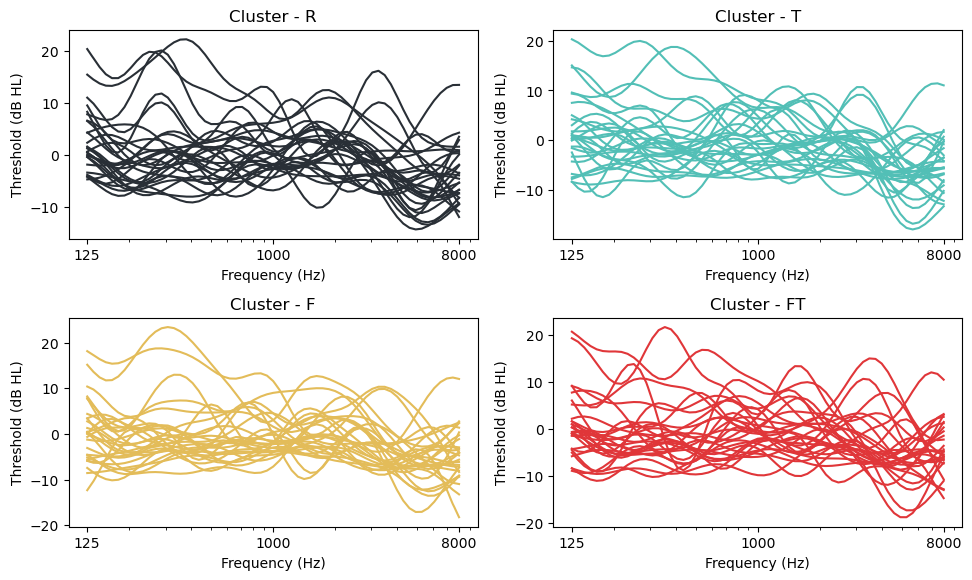

In [8]:
# Randomized
plt.figure(figsize=[25/2.54, 10/2.54])
preproc.plot_recomputed_audiograms(recomputed_Bayes, paradigm='Bayesian', colormap=colormap)
plt.tight_layout()
plt.show()

# Continuous
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    preproc.plot_recomputed_audiograms(recomputed_Con[pred], paradigm="Continuous", pred=pred)
plt.tight_layout()
plt.show()

# Cluster
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    preproc.plot_recomputed_audiograms(recomputed_Clus[pred], paradigm='Cluster', pred=pred)
plt.tight_layout()
plt.show()

## Resampling

### Perform resampling

In [9]:
resampled_Bayes = preproc.load_or_resample_and_save_audiograms(
    'Bayesian', recomputed_Bayes, xfreqs, aud_dir=bayes_aud_dir,
    overwrite=overwrite_existing_audiograms
)

resampled_Cluster = {}
resampled_Continuous = {}

for pred in preds:
    resampled_Cluster[pred] = preproc.load_or_resample_and_save_audiograms(
            'Cluster', recomputed_Clus[pred], xfreqs, aud_dir=clus_aud_dir,
            overwrite=overwrite_existing_audiograms, pred=pred
        )

    resampled_Continuous[pred] = preproc.load_or_resample_and_save_audiograms(
        'Continuous', recomputed_Con[pred], xfreqs, aud_dir=cont_aud_dir,
        overwrite=overwrite_existing_audiograms, pred=pred
    )


---------------- Bayesian ----------------
----------------
tlvjds 

Saving resampled audiogram of tlvjds in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------
nlhglm 

Saving resampled audiogram of nlhglm in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------
klxufm 

Saving resampled audiogram of klxufm in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------
rdzaqd 

Saving resampled audiogram of rdzaqd in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------
vqnuwy 

Saving resampled audiogram of vqnuwy in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------
wfoooa 

Saving resampled audiogram of wfoooa in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------
cbtxie 

Saving resampled audiogram of cbtxie in there_will_be_beeps/data/audiograms/with_init/Bayesian...
----------------
udoety 

Saving resampled audiogram of udoety in there_will_be_beeps/dat

### Plot resampled data

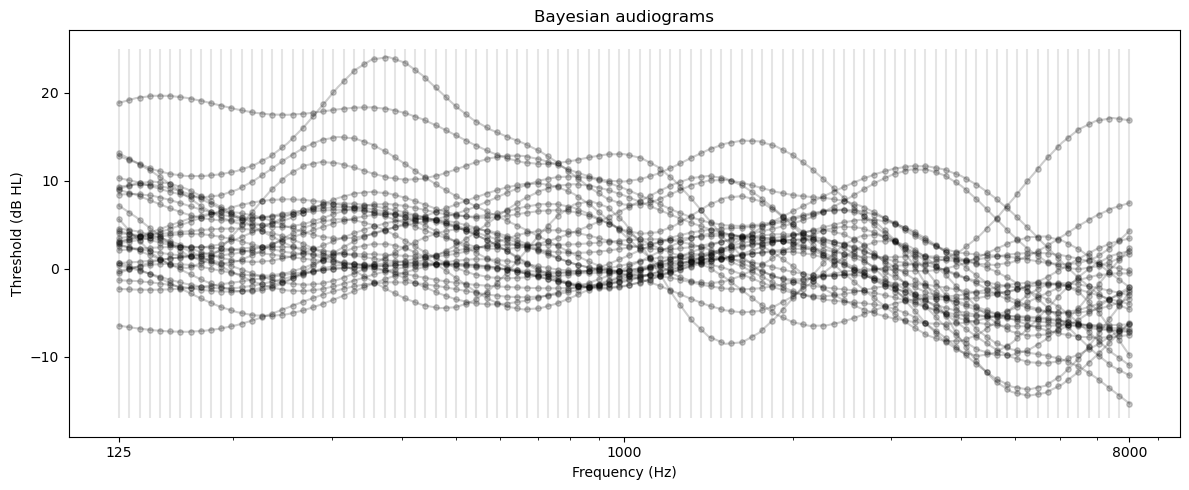

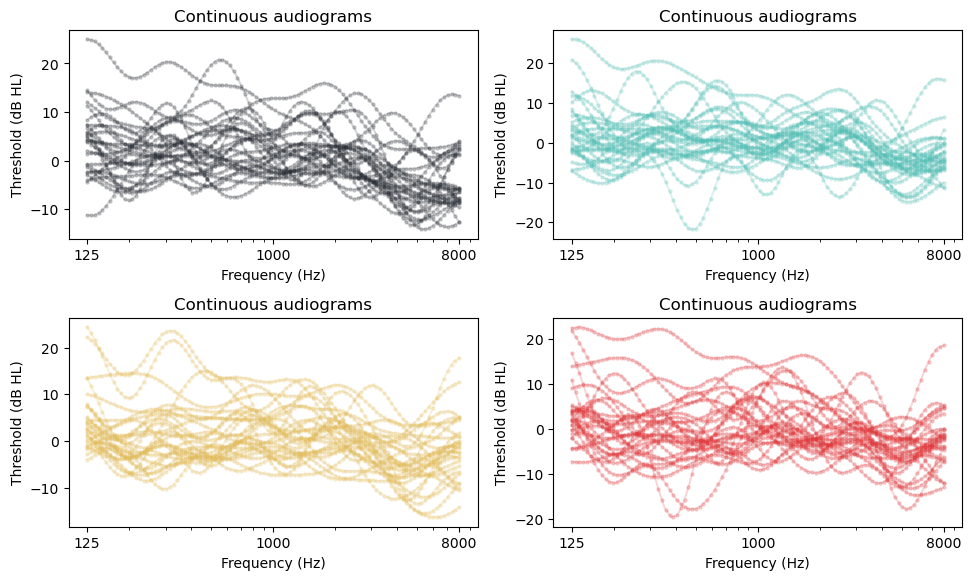

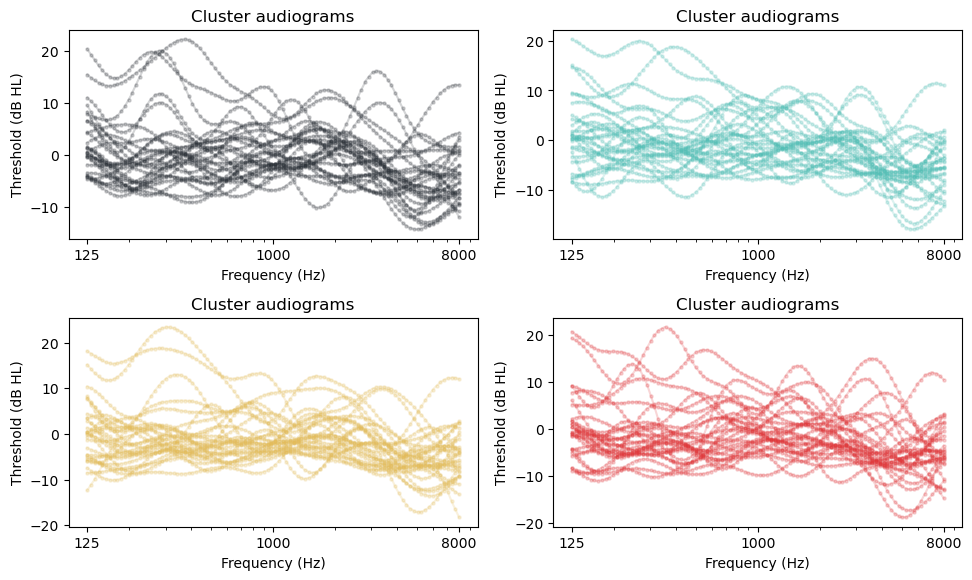

In [10]:
# Randomized
plt.figure(figsize=[12, 5])
plt.vlines(xfreqs, -17, 25, colors='k', alpha=.1)
preproc.plot_resampled_audiograms(recomputed_Bayes, resampled_Bayes, xfreqs, paradigm='Bayesian')
plt.tight_layout()
plt.show()

# Continuous
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    preproc.plot_resampled_audiograms(recomputed_Con[pred], resampled_Continuous[pred], xfreqs, paradigm='Continuous', pred=pred)
plt.tight_layout()
plt.show()

# Cluster
plt.subplots(2, 2, figsize=[25/2.54, 15/2.54])
for n, pred in enumerate(preds):
    plt.subplot(2, 2, n + 1)
    preproc.plot_resampled_audiograms(recomputed_Clus[pred], resampled_Cluster[pred], xfreqs, paradigm='Cluster', pred=pred)
plt.tight_layout()
plt.show()
